## El siguiente ejemplo muestra algunas ideas para automatizar transformaciones y evitar la fuga de datos.

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

In [3]:
#Imputador con columnas, estrategia por composicion
class Plantilla(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass        
    def fit(self, X, y=None):
        return self    
    def get_feature_names_out(self):
        return None
    def  transform(self, X):
        return None

In [ ]:
#X, y = make_classification(n_samples=10, n_features=3, n_informative=3, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1)
#df = pd.DataFrame(X, columns=["col1", "col2", "col3"])
#df["target"] = y
#sns.pairplot(df, hue='target')


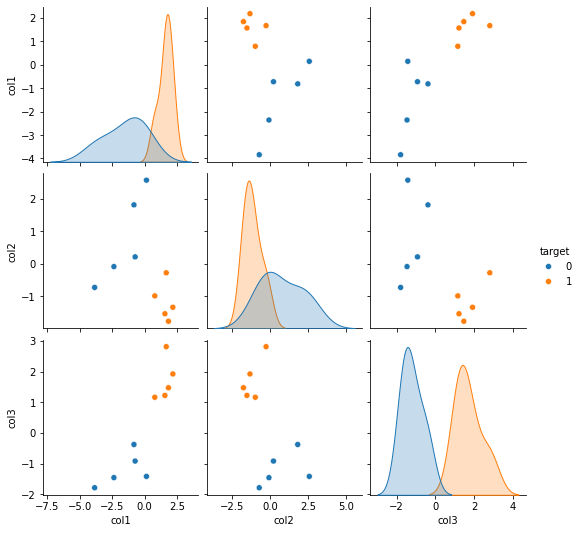

In [3]:
df = pd.DataFrame({"col1":[-0.73,-2.36, 2.17, 0.14, -0.82, 1.83,  1.66, -3.84,  0.78 ,  1.56],
                   "col2":[ 0.21, -0.089 , -1.34,  2.57,  1.81, -1.77, -0.28, -0.73, -0.99, -1.54],
                   "col3":[-0.92, -1.46,  1.92 , -1.42 , -0.38, 1.47,  2.81, -1.79,  1.16,  1.22],
                   "cat":["B", "B", "M", "B", "B", "M", "M", "B", "M", "M"],
                   "target":[0, 0, 1, 0, 0, 1, 1, 0, 1, 1]})
sns.pairplot(df[["col1", "col2", "col3", "target"]], hue='target')


In [3]:
df = pd.DataFrame({"col1":[-0.73,-2.36, 2.17, np.nan, -0.82, 1.83,  1.66, np.nan,  0.78 ,  1.56],
                   "col2":[ 0.21, -0.089 , -1.34,  2.57,  1.81, -1.77, -0.28, -0.73, -0.99, -1.54],
                   "col3":[-0.92, np.nan,  1.92 , -1.42 , -0.38, 1.47,  np.nan, -1.79,  np.nan,  1.22],
                   "cat":["B", "B", "M", "B", "B", "M", "M", "B", "M", "M"],
                   "target":[0, 0, 1, 0, 0, 1, 1, 0, 1, 1]})
#sns.pairplot(df[["col1", "col2", "col3", "target"]], hue='target')
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)

Pipeline permite encadenar transformaciones. Una incomodidad cuando un sistema esta preproductivo o tiene transformaciones que implican nuevos datos es la perdida de los nombre de columnas.

Ejemplo con SimpleImputer

In [4]:
si = SimpleImputer()
si.fit(X_train[["col1"]])
si.transform(X_train[["col1"]])

array([[ 2.17 ],
       [ 1.56 ],
       [ 1.66 ],
       [ 1.088],
       [-0.73 ],
       [ 1.088],
       [ 0.78 ]])

Manualmente es posible asignarlo al dataframe y mantener el nombre de la columna

In [5]:
X_train.loc[:, "col1"] = si.transform(X_train[["col1"]])

Si bien es posible hacerlo, necesito una forma de automatizar las transformaciones, el objetivo final es automatizar todo en pipelines y probar distintas alternativas (en distintos pipelines posiblemente con gridsearchcv) de forma controlada. Recordar la recomendacion de usar pipelines para evitar fuga de datos en el sistema en produccion.

Las alternativas del tipo columntransformer pueden ser utiles en sistemas en produccion, durante al exploracion de transformaciones y modelos presentan dificultades por al perdida de nombre de columnas y se vuelven complicado el seguimiento de las transformaciones y sus implicancias.

Una solucion relativamente sencilla (a mi juicio la mejor) de aplicar transformaciones es crear transformadores customizados, muchas veces son simplemente envoltorios o "wrappers" de clases sklearn. Solo hay que implementar algunos metodos para que la clase Pipeline pueda hacer las transformaciones en orden. 

In [6]:
#Imputador con columnas, estrategia por composicion
class ColImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(), columns=[]):
        super().__init__()
        self.imputer = imputer
        self.columns = columns        
        
    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self    
    
    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()
    
    def  transform(self, X):
        Xc = X.copy()        
        Xc.loc[:, self.columns] = self.imputer.transform(Xc[self.columns])
        return Xc

In [7]:
si = ColImputer(imputer=SimpleImputer(strategy='median'), columns=["col3"])
si.fit(X_train)
si.transform(X_train)
si.transform(X_test)


,col1,col2,col3,cat
5,1.83,-1.770,1.47,M
4,-0.82,1.810,-0.38,B
1,-2.36,-0.089,-0.92,B


In [8]:

class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None, columns=[]):
        super().__init__()
        self.encoder = encoder
        self.columns = columns        
        
    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    
    def get_feature_names_out(self):
        return self.get_feature_names_out()
    
    def  transform(self, X):
        Xc = X.copy()        
        Xc.loc[:, self.columns] = self.encoder.transform(Xc[self.columns])
        return Xc


Pruebo individualmente el ColOneHot

In [9]:
enc = ColOneHot(encoder=OneHotEncoder(sparse_output=False, drop='first', dtype=int), columns=["cat"])
enc.fit(X_train)
enc.transform(X_train)

,col1,col2,col3,cat
2,2.170,-1.34,1.92,1
9,1.560,-1.54,1.22,1
6,1.660,-0.28,NaN,1
7,1.088,-0.73,-1.79,0
0,-0.730,0.21,-0.92,0
3,1.088,2.57,-1.42,0
8,0.780,-0.99,NaN,1


In [10]:
ci = ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["col1", "col2", "col3"])
ci.fit(X_train)
X_train = ci.transform(X_train)
X_test = ci.transform(X_test)

In [11]:
X_test

,col1,col2,col3,cat
5,1.83,-1.770,1.470,M
4,-0.82,1.810,-0.380,B
1,-2.36,-0.089,-0.198,B


Pruebo todo en un pipeline

In [12]:
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)

pl = Pipeline(steps=[
    ("ImpCol1Col2", ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["col1", "col2", "col3"])),
    ("OneHot", ColOneHot(encoder=OneHotEncoder(sparse_output=False, drop='first', dtype=int), columns=["cat"])),
    
    
])
pl.fit(X_train, y_train)


Pipeline(steps=[('ImpCol1Col2', ColImputer(columns=['col1', 'col2', 'col3'])),
                ('OneHot',
                 ColOneHot(columns=['cat'],
                           encoder=OneHotEncoder(drop='first',
                                                 dtype=<class 'int'>,
                                                 sparse_output=False)))])

In [101]:
pl.transform(X_train)

,col1,col2,col3,cat
2,2.170,-1.34,1.920,1
9,1.560,-1.54,1.220,1
6,1.660,-0.28,-0.198,1
7,1.088,-0.73,-1.790,0
0,-0.730,0.21,-0.920,0
3,1.088,2.57,-1.420,0
8,0.780,-0.99,-0.198,1


In [13]:
#hagamos la clasificacion
pl.steps.append(("clf", KNeighborsClassifier(n_neighbors=2)))


In [14]:

pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



## Ahora tenemos un nuevo set de datos de produccion, tenemos que aplicar las mismas transformaciones

# Práctica

## Parte 1

Desarrollar una clase que aplique un escalador "StandarScaler" o "MinMaxScaler" sobre una lista de columnas determinadas. </BR>
Agregar el transformador en el pipeline antes de aplicar KNN

## Parte 2

Trabajo práctico final: Identifique nulos, valores anomalos, outliers y desarrolle un trasformador que impute o elimine según su percepción.